In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import caiman as cm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
%load_ext autoreload
%autoreload 2
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)
from utils.video import videoWrite
import moviepy.editor as mpy

## 1. Load data

In [2]:
imgStack = np.load('Data/3D_CW_data/17-08-24-L2-CL-VNC-Raw.npy')
Y = imgStack.copy()
Y = Y.transpose([2, 3, 1, 0]) # x, y, z, T
dx, dy, dz, dt = Y.shape

## 2. Detrend raw signal on pixels

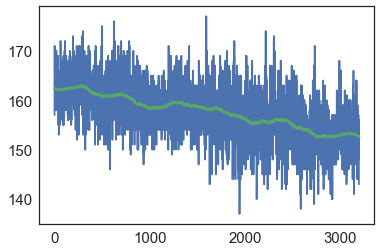

In [3]:
# from scipy import signal
# Ysg = signal.savgol_filter(Y, 511, 3, axis=-1)
# np.save('tmpData/Y_sg_CW_VNC', Ysg)
Ysg = np.load('tmpData/Y_sg_CW_VNC.npy')
Y_detr = Y - Ysg

#
# compare raw pixel and trend
plt.plot(Y[0, 0, 0, :])
plt.plot(Ysg[0, 0, 0, :], linewidth=3)
plt.show()

## 3.Spatial denoising using patched SVD (Greedy algorithm)

### 3.1 Denoising for independent images per stack along z

In [4]:
# from spatialDenoising.denoise import temporal as svd_patch
# nblocks=[5, 5]
# dx=4
# maxlag=5
# confidence=0.99
# greedy=False,
# fudge_factor=1
# mean_th_factor=1.15
# U_update=False
# min_rank=1
# stim_knots=None
# stim_delta=0

# Y_svd = Y_detr.copy()
# for nDepth in range(Y_detr.shape[2]):
#     img = np.squeeze(Y_detr[:, :, nDepth, :])
#     Y_svd[:, :, nDepth, :], _ = svd_patch(img, nblocks=nblocks, dx=dx, stim_knots=stim_knots, stim_delta=stim_delta)

# np.save('Y_svd_CW_VNC', Y_svd)

In [5]:
Y_svd = np.load('tmpData/Y_svd_CW_VNC.npy')
Y_svd_sg = Y_svd + Ysg

#### Performance for selected image

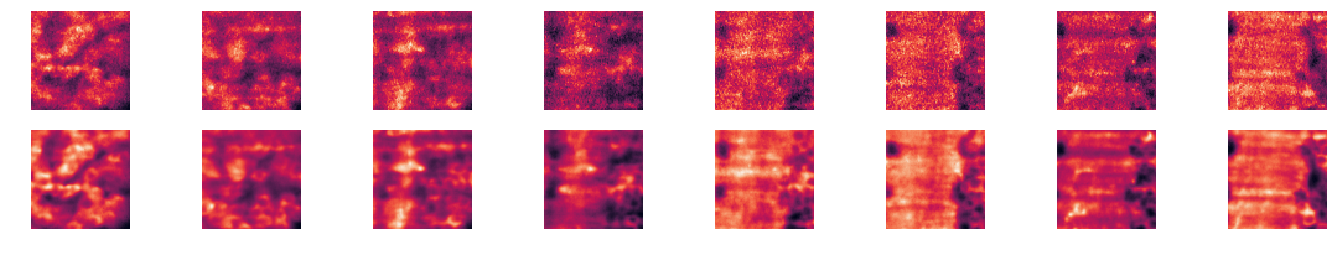

In [6]:
numCol = 8
step = dz//numCol
fig, ax = plt.subplots(2, numCol, figsize=(24, 4))
for nplot in range(numCol):
    ax[0, nplot].imshow(Y[:, :, step*nplot, 810])
    ax[0, nplot].axis('off')
    ax[1, nplot].imshow(Y_svd_sg[:, :, step*nplot, 810])
    ax[1, nplot].axis('off')
plt.show()

# fig, ax = plt.subplots(2, numCol, figsize=(24, 4))
# for nplot in range(numCol):
#     ax[0, nplot].imshow(Y[:, :, step*nplot, 800], vmin=Y.min(), vmax=Y.max())
#     ax[0, nplot].axis('off')
#     ax[1, nplot].imshow(Y_svd[:, :, step*nplot, 800], vmin=-Y_svd.std(), vmax=Y_svd.std())
#     ax[1, nplot].axis('off')
# plt.show()

#### Performance on single pixels

In [7]:
percentage_noise = ((Y_detr - Y_svd)**2).mean(axis=-1)/Y_detr.var(axis=-1)
print('Average percentage noise removed %f'%(percentage_noise[:].mean()))

Average percentage noise removed 0.810940


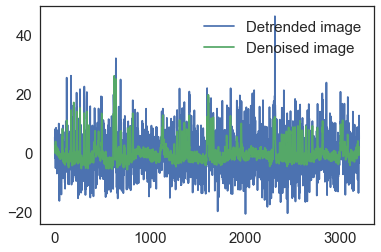

In [8]:
plt.plot(Y_detr[70, 40, 20, :], label='Detrended image')
plt.plot(Y_svd[70, 40, 20, :], label='Denoised image')
plt.legend()
plt.show()

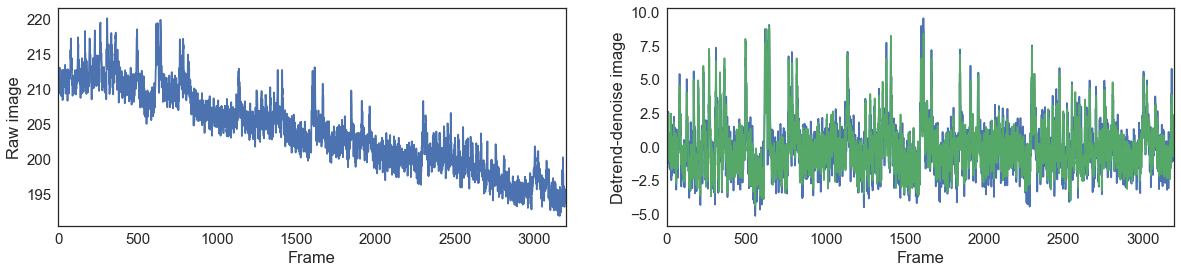

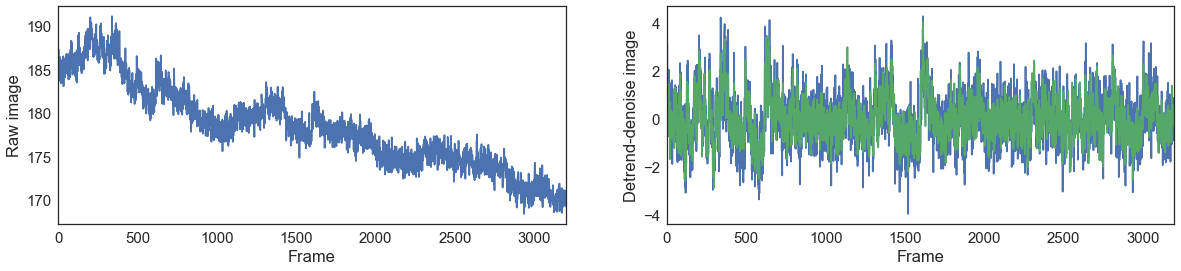

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(Y[0:10, 70:79, step*6, :].mean(axis=0).mean(axis=0))
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Raw image')
ax[0].set_xlim([0, dt])

ax[1].plot(Y_detr[0:10, 70:79, step*6, :].mean(axis=0).mean(axis=0))
ax[1].plot(Y_svd[0:10, 70:79, step*6, :].mean(axis=0).mean(axis=0))
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Detrend-denoise image')
ax[1].set_xlim([0, dt])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(Y[70:79, 50:59, step*2, :].mean(axis=0).mean(axis=0))
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Raw image')
ax[0].set_xlim([0, dt])

ax[1].plot(Y_detr[70:79, 50:59, step*2, :].mean(axis=0).mean(axis=0))
ax[1].plot(Y_svd[70:79, 50:59, step*2, :].mean(axis=0).mean(axis=0))
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Detrend-denoise image')
ax[1].set_xlim([0, dt])
plt.show()

In [10]:
# raw
numCol = 8
video_mat_raw = np.empty((numCol*dx, dy, dt))
step = dz//numCol
for nDepth in range(numCol):
    video_mat_raw[nDepth*Y.shape[0]+np.arange(dx), :, :] = Y[:, :, nDepth*step, :]

# detred
video_mat_detr = np.empty((numCol*dx, dy, dt))
step = dz//numCol
for nDepth in range(numCol):
    video_mat_detr[nDepth*Y.shape[0]+np.arange(dx), :, :] = Y_detr[:, :, nDepth*step, :]

# svd
video_mat_svd = np.empty((numCol*dx, dy, dt))
step = dz//numCol
for nDepth in range(numCol):
    video_mat_svd[nDepth*Y.shape[0]+np.arange(dx), :, :] = Y_svd[:, :, nDepth*step, :]

video_mat_res = video_mat_detr - video_mat_svd

In [11]:
# video_mat_raw = (video_mat_raw - video_mat_raw.min())/(video_mat_raw.max()-video_mat_raw.min())
# video_mat_detr = (video_mat_detr - video_mat_detr.min())/(video_mat_detr.max() - video_mat_detr.min())
# video_mat_svd = (video_mat_svd - video_mat_svd.min())/(video_mat_svd.max()-video_mat_svd.min())
# video_mat_res = (video_mat_res - video_mat_res.min())/(video_mat_res.max()-video_mat_svd.min())
# video_null = np.zeros((numCol*dx, 16, dt))

# movie = np.concatenate((video_mat_raw, video_null, video_mat_detr, video_null, video_mat_svd, video_null, video_mat_res), axis=1)

In [12]:
# videoWrite(movie.transpose(2, 0, 1), 'movie_CW_VNC.mp4')
# mpy.ipython_display('movie_CW_VNC.mp4', fps=30, loop=False, autoplay=False, maxduration=120)

### 3.2 Denoising for consecutive stacks

In [13]:
def low_rank_svd(img, rank_k):
    from sklearn.utils.extmath import randomized_svd
    dx, dy, dt = img.shape
    vec_img = img.reshape(dx*dy, dt)
    U, s, Vt = randomized_svd(vec_img, n_components=rank_k, n_iter=7, random_state=None)
    return U.dot(np.diag(s).dot(Vt)).reshape((dx, dy, dt))

In [14]:
def pad_index(arr, overlap_step, max_value):
    if arr[0]>overlap_step:
        arr = np.append(arr, arr[0]+np.arange(-overlap_step,0))
    if arr.max()<max_value-overlap_step:
        arr = np.append(arr, arr.max()+np.arange(1,overlap_step))
    return np.sort(arr.flatten())

def split_to_blocks(nsize, nblocks, overlap_step):
    assert len(nsize) == len(overlap_step), print("lengths not matched")
    arr = []
    for nsize_, nblock_, overlap_ in zip(nsize, nblocks, overlap_step):
        arr_ = np.array_split(range(nsize_), nblock_)
        arr_ = [pad_index(_, overlap_, nsize_) for _ in arr_]
        arr.append(arr_)
    return arr

In [15]:
def get_blocks_from_index_arr(imgStack, arrs):
    blocks = []
    for z_arr in arrs[0]:
        for x_arr in arrs[1]:
            for y_arr in arrs[2]:
                block_ = imgStack[z_arr.min():z_arr.max()+1, x_arr.min():x_arr.max()+1, y_arr.min():y_arr.max()+1, :]
                blocks.append([block_, z_arr, x_arr, y_arr])
    return blocks

In [16]:
def run_single(blocks, maxlag=5, confidence=0.999, greedy=False, fudge_factor=0.99, mean_th_factor=1.15,
               U_update=False, min_rank=1, stim_knots=None, stim_delta=200):
    
    from spatialDenoising import greedyPCA as gpca
    import time
    import multiprocessing
    from functools import partial
    
    func = partial(gpca.denoise_patch, maxlag=maxlag, confidence=confidence, greedy=greedy,
                                  fudge_factor=fudge_factor, mean_th_factor=mean_th_factor, U_update=U_update,
                                  min_rank=min_rank, stim_knots=stim_knots, stim_delta=stim_delta)
    
    start=time.time()
    cpu_count = max(1, multiprocessing.cpu_count()-2)
    args=[patch[0] for patch in blocks]
    start=time.time()
    pool = multiprocessing.Pool(cpu_count)
    print('Running %d blocks in %d cpus'%(len(blocks), cpu_count))#if verbose else 0
    # define params in function
    c_outs = pool.map(func, args)
    pool.close()
    pool.join()
    
    Yds = [out_[0] for out_ in c_outs]
    vtids = [out_[1] for out_ in c_outs]
    vtids = np.asarray(vtids).astype('int')
    print('Blocks(=%d) run time: %f'%(len(Y),time.time()-start))
    
    return Yds, vtids

In [17]:
def combine_blocks(block_data, block_size, block_corrs):
    block_mat = np.zeros(block_size)
    block_count = block_mat.copy().astype(np.int)
    for ndata, ncorr in zip(block_data, block_corrs):
        _, z_arr, x_arr, y_arr = ncorr
        block_mat[z_arr.min():z_arr.max()+1, x_arr.min():x_arr.max()+1, y_arr.min():y_arr.max()+1, :] += ndata
        block_count[z_arr.min():z_arr.max()+1, x_arr.min():x_arr.max()+1, y_arr.min():y_arr.max()+1, :] += 1
    return block_mat, block_count

In [18]:
Y_detr_ave = Y_detr.mean(axis=-1) # remove mean
Y_detr_std = Y_detr.std(axis=-1) # normalization
Y_detr_ = Y_detr.transpose([2, 0, 1, 3])
Y_detr_ = (Y_detr_ - Y_detr_.mean(axis=-1)[:,:,:,np.newaxis])/Y_detr_.std(axis=-1)[:,:,:,np.newaxis]

In [19]:
# remove top few (6) components in each z of stack
rank_k = 6
Y_low_rank = [low_rank_svd(slice_, rank_k) for slice_ in Y_detr_]
Y_detr_ = Y_detr_ - Y_low_rank

In [20]:
nx = 5
ny = 5
zstack_step = 4
nz = np.ceil(dz/zstack_step).astype('int')
ox = 2
oy = 2
oz = 1
arrs = split_to_blocks((dx, dy, dz), (nx, ny, nz), (ox, oy, oz))
arrs = [arrs[2], arrs[0], arrs[1]]
blocks = get_blocks_from_index_arr(Y_detr_, arrs)

In [21]:
maxlag=5
confidence=0.99
greedy=False
fudge_factor=1
mean_th_factor=1.15
U_update=False
min_rank=1
stim_knots=None
stim_delta=0
interleave=False

block_Y_cubic_svd, block_rank = run_single(blocks, maxlag=maxlag, confidence=confidence, greedy=greedy, 
                                fudge_factor=fudge_factor, mean_th_factor=mean_th_factor, U_update=U_update, 
                                min_rank=min_rank, stim_knots=stim_knots, stim_delta=stim_delta)


Running 150 blocks in 30 cpus
	M	rank: 4	run_time: 87.850377
	M	rank: 7	run_time: 109.911499
	M	rank: 1	run_time: 114.669281
	M	rank: 1	run_time: 124.106176
	M	rank: 4	run_time: 123.843521
	M	rank: 4	run_time: 126.651911
	M	rank: 7	run_time: 124.081304
	M	rank: 8	run_time: 127.893599
	M	rank: 4	run_time: 135.305061
	M	rank: 6	run_time: 135.945905
	M	rank: 9	run_time: 177.735070
	M	rank: 10	run_time: 175.985644
	M	rank: 3	run_time: 173.400926
	M	rank: 2	run_time: 102.252130
	M	rank: 3	run_time: 174.768375
	M	rank: 4	run_time: 173.509787
	M	rank: 1	run_time: 191.302397
	M	rank: 2	run_time: 149.336098
	M	rank: 8	run_time: 200.959046
	M	rank: 4	run_time: 197.560580
	M	rank: 2	run_time: 134.778759
	M	rank: 4	run_time: 209.405628
	M	rank: 5	run_time: 189.934736
	M	rank: 2	run_time: 189.231490
	M	rank: 9	run_time: 113.052087
	M	rank: 3	run_time: 156.531899
	M	rank: 7	run_time: 121.988437
	M	rank: 8	run_time: 187.154102
	M	rank: 8	run_time: 115.624593
	M	rank: 5	run_time: 132.007978
	M	rank: 6

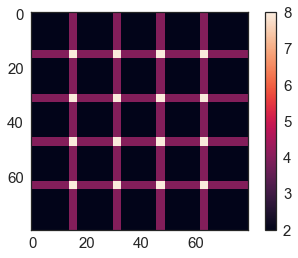

In [22]:
block_mat, block_cout = combine_blocks(block_Y_cubic_svd, Y_detr_.shape, blocks)
plt.imshow(block_cout[3, :, :, 0])
plt.colorbar()
plt.show()

In [23]:
Y_cubic_svd = block_mat/block_cout
Y_cubic_svd = Y_cubic_svd + Y_low_rank
Y_cubic_svd = Y_cubic_svd.transpose([1, 2, 0, 3])
Y_cubic_svd = (Y_cubic_svd + Y_detr_ave[:,:,:,np.newaxis])*Y_detr_std[:,:,:,np.newaxis]

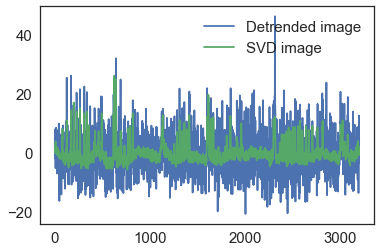

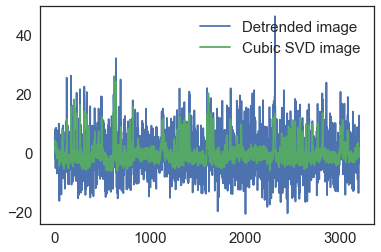

In [24]:
plt.plot(Y_detr[70, 40, 20, :], label='Detrended image')
plt.plot(Y_svd[70, 40, 20, :], label='SVD image')
plt.legend()
plt.show()
plt.plot(Y_detr[70, 40, 20, :], label='Detrended image')
plt.plot(Y_cubic_svd[70, 40, 20, :], label='Cubic SVD image')
plt.legend()
plt.show()

In [25]:
percentage_noise = ((Y_detr - Y_svd)**2).mean(axis=-1)/Y_detr.var(axis=-1)
percentage_c_noise = ((Y_detr - Y_cubic_svd)**2).mean(axis=-1)/Y_detr.var(axis=-1)
print('Average percentage noise removed %f'%(percentage_noise[:].mean()))
print('Average percentage noise removed %f'%(percentage_c_noise[:].mean()))

Average percentage noise removed 0.810940
Average percentage noise removed 0.810688


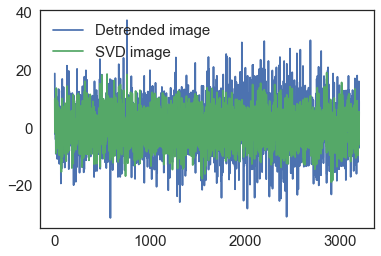

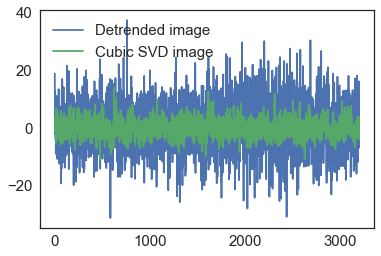

In [26]:
diff = percentage_c_noise - percentage_noise
ind = np.where(diff==diff.max())
plt.plot(Y_detr[ind[0][0], ind[1][0], ind[2][0], :], label='Detrended image')
plt.plot(Y_svd[ind[0][0], ind[1][0], ind[2][0], :], label='SVD image')
plt.legend()
plt.show()
plt.plot(Y_detr[ind[0][0], ind[1][0], ind[2][0], :], label='Detrended image')
plt.plot(Y_cubic_svd[ind[0][0], ind[1][0], ind[2][0], :], label='Cubic SVD image')
plt.legend()
plt.show()

In [27]:
np.save('tmpData/Y_csvd_CW_VNC.npy', Y_cubic_svd)
Y_cubic_svd = np.load('tmpData/Y_csvd_CW_VNC.npy')
Y_cubic_svd_sg = Y_cubic_svd + Ysg

#### Comparing to indepedent z-stack

In [28]:
nx = 5
ny = 5
zstack_step = 1
nz = np.ceil(dz/zstack_step).astype('int')
ox = 2
oy = 2
oz = 0
arrs = split_to_blocks((dx, dy, dz), (nx, ny, nz), (ox, oy, oz))
arrs = [arrs[2], arrs[0], arrs[1]]
blocks = get_blocks_from_index_arr(Y_detr_, arrs)

In [29]:
maxlag=5
confidence=0.99
greedy=False
fudge_factor=1
mean_th_factor=1.15
U_update=False
min_rank=1
stim_knots=None
stim_delta=0
interleave=False

block_Y_cubic_svd_, block_rank_ = run_single(blocks, maxlag=maxlag, confidence=confidence, greedy=greedy, 
                                fudge_factor=fudge_factor, mean_th_factor=mean_th_factor, U_update=U_update, 
                                min_rank=min_rank, stim_knots=stim_knots, stim_delta=stim_delta)

Running 550 blocks in 30 cpus
	M	rank: 1	run_time: 31.212362
	M	rank: 6	run_time: 30.607213
	M	rank: 1	run_time: 29.633865
	M	rank: 1	run_time: 31.504476
	M	rank: 2	run_time: 30.319711
	M	rank: 3	run_time: 35.103370
	M	rank: 6	run_time: 36.187362
	M	rank: 4	run_time: 31.200653
	M	rank: 2	run_time: 32.062966
	M	rank: 6	run_time: 37.729758
	M	rank: 6	run_time: 38.881520
	M	rank: 1	run_time: 36.904221
	M	rank: 1	run_time: 38.984324
	M	rank: 5	run_time: 29.576418
	M	rank: 4	run_time: 35.409526
	M	rank: 1	run_time: 40.311802
	M	rank: 1	run_time: 38.162134
	M	rank: 2	run_time: 27.263923
	M	rank: 2	run_time: 41.988161
	M	rank: 1	run_time: 37.157375
	M	rank: 2	run_time: 34.350845
	M	rank: 1	run_time: 38.961597
	M	rank: 2	run_time: 37.817221
	M	rank: 3	run_time: 54.489269
	M	rank: 3	run_time: 36.393373
	M	rank: 6	run_time: 44.630142
	M	rank: 3	run_time: 48.378399
	M	rank: 8	run_time: 32.743492
	M	rank: 2	run_time: 41.847036
	M	rank: 2	run_time: 48.761865
	M	rank: 3	run_time: 59.135565
	M	rank: 

	M	rank: 1	run_time: 36.597222
	M	rank: 1	run_time: 38.801571
	M	rank: 4	run_time: 24.551628
	M	rank: 3	run_time: 38.843820
	M	rank: 1	run_time: 37.047528
	M	rank: 2	run_time: 47.784654
	M	rank: 2	run_time: 38.538594
	M	rank: 2	run_time: 33.203927
	M	rank: 1	run_time: 44.133696
	M	rank: 2	run_time: 35.637264
	M	rank: 4	run_time: 25.481117
	M	rank: 1	run_time: 35.342573
	M	rank: 2	run_time: 43.079207
	M	rank: 3	run_time: 41.165138
	M	rank: 1	run_time: 37.632832
	M	rank: 3	run_time: 37.106293
	M	rank: 2	run_time: 26.924843
	M	rank: 3	run_time: 33.044007
	M	rank: 1	run_time: 39.563129
	M	rank: 2	run_time: 19.533544
	M	rank: 1	run_time: 29.956478
	M	rank: 1	run_time: 22.594824
	M	rank: 3	run_time: 26.921655
	M	rank: 3	run_time: 42.529338
	M	rank: 2	run_time: 35.275722
	M	rank: 4	run_time: 31.888731
	M	rank: 3	run_time: 27.470035
	M	rank: 2	run_time: 32.750415
	M	rank: 2	run_time: 34.610081
	M	rank: 2	run_time: 38.657580
	M	rank: 2	run_time: 26.748690
	M	rank: 2	run_time: 18.420894
	M	rank:

	M	rank: 7	run_time: 27.120587
	M	rank: 4	run_time: 29.640854
	M	rank: 5	run_time: 29.683464
	M	rank: 4	run_time: 27.532146
	M	rank: 4	run_time: 21.685212
	M	rank: 2	run_time: 16.948239
	M	rank: 2	run_time: 25.964854
	M	rank: 4	run_time: 26.639051
	M	rank: 2	run_time: 23.594035
	M	rank: 4	run_time: 23.576018
	M	rank: 5	run_time: 14.216714
	M	rank: 3	run_time: 25.842223
	M	rank: 2	run_time: 17.022453
	M	rank: 2	run_time: 21.424907
	M	rank: 5	run_time: 17.052476
	M	rank: 5	run_time: 14.287840
	M	rank: 2	run_time: 8.541173
	M	rank: 3	run_time: 11.021756
	M	rank: 4	run_time: 7.988420
	M	rank: 1	run_time: 13.778359
	M	rank: 2	run_time: 7.338297
Blocks(=80) run time: 714.021312


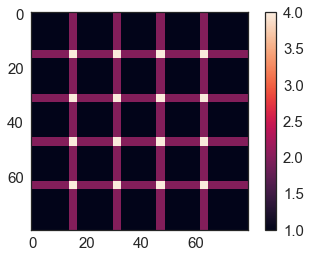

In [30]:
block_mat, block_cout = combine_blocks(block_Y_cubic_svd_, Y_detr_.shape, blocks)
plt.imshow(block_cout[3, :, :, 0])
plt.colorbar()
plt.show()

In [31]:
Y_cubic_svd_ = block_mat/block_cout
Y_cubic_svd_ = Y_cubic_svd_ + Y_low_rank
Y_cubic_svd_ = Y_cubic_svd_.transpose([1, 2, 0, 3])
Y_cubic_svd_ = (Y_cubic_svd_ + Y_detr_ave[:,:,:,np.newaxis])*Y_detr_std[:,:,:,np.newaxis]

In [32]:
percentage_noise = ((Y_detr - Y_cubic_svd_)**2).mean(axis=-1)/Y_detr.var(axis=-1)
percentage_c_noise = ((Y_detr - Y_cubic_svd)**2).mean(axis=-1)/Y_detr.var(axis=-1)
print('Average percentage noise removed %f'%(percentage_noise[:].mean()))
print('Average percentage noise removed %f'%(percentage_c_noise[:].mean()))

Average percentage noise removed 0.809467
Average percentage noise removed 0.810688


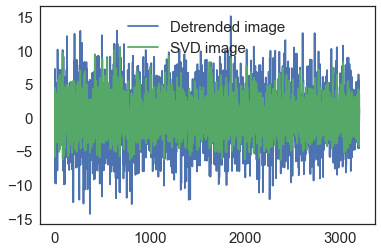

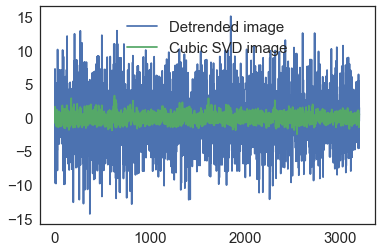

In [33]:
diff = percentage_c_noise - percentage_noise
ind = np.where(diff==diff.max())
plt.plot(Y_detr[ind[0][0], ind[1][0], ind[2][0], :], label='Detrended image')
plt.plot(Y_cubic_svd_[ind[0][0], ind[1][0], ind[2][0], :], label='SVD image')
plt.legend()
plt.show()
plt.plot(Y_detr[ind[0][0], ind[1][0], ind[2][0], :], label='Detrended image')
plt.plot(Y_cubic_svd[ind[0][0], ind[1][0], ind[2][0], :], label='Cubic SVD image')
plt.legend()
plt.show()

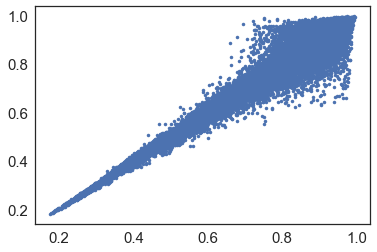

In [34]:
plt.plot(percentage_c_noise.flatten(), percentage_noise.flatten(), '.')

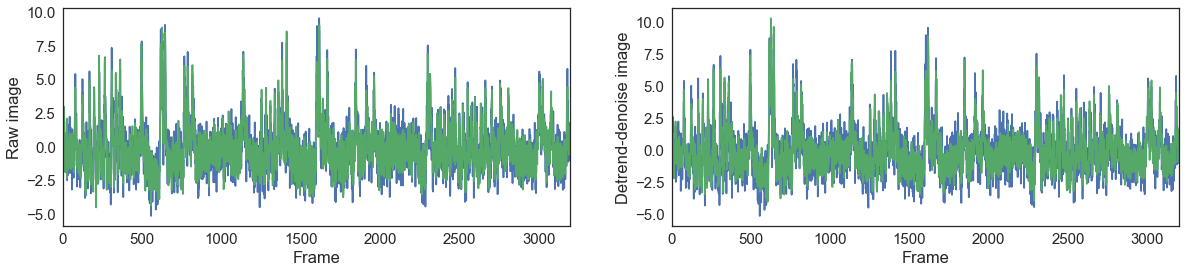

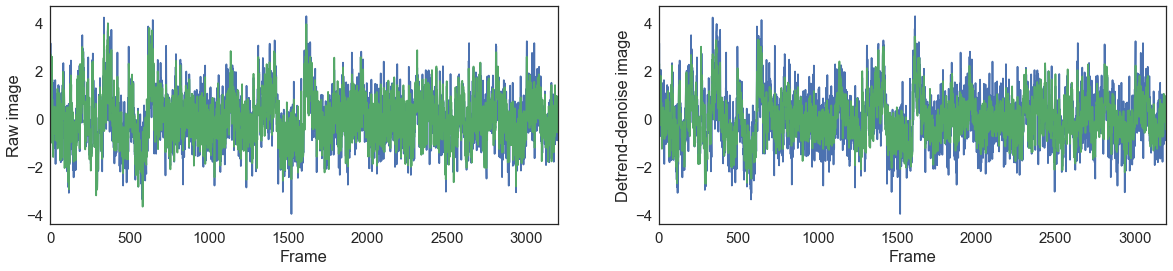

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(Y_detr[0:10, 70:79, step*6, :].mean(axis=0).mean(axis=0))
ax[0].plot(Y_cubic_svd_[0:10, 70:79, step*6, :].mean(axis=0).mean(axis=0))
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Raw image')
ax[0].set_xlim([0, dt])

ax[1].plot(Y_detr[0:10, 70:79, step*6, :].mean(axis=0).mean(axis=0))
ax[1].plot(Y_cubic_svd[0:10, 70:79, step*6, :].mean(axis=0).mean(axis=0))
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Detrend-denoise image')
ax[1].set_xlim([0, dt])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(Y_detr[70:79, 50:59, step*2, :].mean(axis=0).mean(axis=0))
ax[0].plot(Y_cubic_svd_[70:79, 50:59, step*2, :].mean(axis=0).mean(axis=0))
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Raw image')
ax[0].set_xlim([0, dt])

ax[1].plot(Y_detr[70:79, 50:59, step*2, :].mean(axis=0).mean(axis=0))
ax[1].plot(Y_cubic_svd[70:79, 50:59, step*2, :].mean(axis=0).mean(axis=0))
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Detrend-denoise image')
ax[1].set_xlim([0, dt])
plt.show()